# Preparing Image Classifier Data
_Author: Nathan Robertson_

It's time to gather my training dataset together and prepare it for a Convolutional Neural Network (CNN).

This notebook is going to prepare the training data, and then pickle it for another notebook. It's a fairly short notebook, but that is because I needed to partition the CNN notebook into a cloud-based notebook to get extra fire power for the specific task that my computer struggled to do locally (creating and training a CNN model).


### Step 0: Import the necessary packages

In [1]:
# Standard data manipulation.
import numpy as np
import pandas as pd

# Handling image extraction.
from PIL import Image
import requests
from io import BytesIO
import os
import random

# Progress tracking.
from tqdm import tqdm

# Step 1: Import the computer labeled data.

I'll read in the data that came from the Azure->OpenAI workflow. 

In [2]:
# Read in CSVs.
df1 = pd.read_csv('gpt_image_labels_v2_1.csv')
df2 = pd.read_csv('gpt_image_labels_v2_2.csv')
df3 = pd.read_csv('gpt_image_labels_v2_3.csv')
df4 = pd.read_csv('gpt_image_labels_v2_4.csv')
df5 = pd.read_csv('gpt_image_labels_v2_5.csv')
df6 = pd.read_csv('gpt_image_labels_v2_6.csv')
df7 = pd.read_csv('gpt_image_labels_v2_7.csv')
df8 = pd.read_csv('gpt_image_labels_v2_8.csv')


# Concatenate data.
computer_labels = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])

In [3]:
# Take a look at data.
computer_labels.head()

,zillowId,url,image_path,label,rank,gpt_description,azure_description,cost,completion_tokens,prompt_tokens
0,2086148031,https://photos.zillowstatic.com/fp/d750d02b5c8...,data/labeled_images/2 - images/cc7Md6VTlIJgo5J...,Kitchen,8.0,"This modern, spacious kitchen features high-qu...","{'modelVersion': '2023-10-01', 'captionResult'...",0.01033,80,793
1,85110763,https://photos.zillowstatic.com/fp/27dfb417e18...,data/labeled_images/2 - images/NGadHDR7DYCyozt...,Location Exterior,4.0,The exterior location in the image depicts a m...,"{'modelVersion': '2023-10-01', 'captionResult'...",0.01030,83,781
2,2055874457,https://photos.zillowstatic.com/fp/1f802f39f73...,data/labeled_images/2 - images/5cWCNKp31aIHl96...,Living Room,6.0,The living room features neutral colors with a...,"{'modelVersion': '2023-10-01', 'captionResult'...",0.01053,82,807
3,25862308,https://photos.zillowstatic.com/fp/96c8ef1085b...,data/labeled_images/2 - images/FArFwWvqv7LOqxh...,Kitchen,4.0,This kitchen has a dated appearance with older...,"{'modelVersion': '2023-10-01', 'captionResult'...",0.01016,75,791
4,116359580,https://photos.zillowstatic.com/fp/e501b9ca6de...,data/labeled_images/2 - images/nwLoOiN80MbTwAV...,Location Exterior,7.0,"The home in the picture showcases a serene, we...","{'modelVersion': '2023-10-01', 'captionResult'...",0.01039,78,805


# Step 2: Import the human labeled data.

Some of the computer labeled data has been reviewed and corrected by me. I'll read in the output of those as well.

In [4]:
# Read in CSVs.
df1 = pd.read_csv('human_reviewed_gpt_labels.csv')
df2 = pd.read_csv('human_reviewed_gpt_labels_v2_1.csv')

# Concatenate data.
human_labels = pd.concat([df1, df2])

In [5]:
# Drop unnecessary columns.
human_labels = human_labels[['zillowId','human_label','human_rank']]

In [6]:
# Take a look at data.
human_labels.head()

,zillowId,human_label,human_rank
0,7.611019e+07,Bathroom,3.0
1,7.525196e+07,Bedroom,5.0
2,2.054614e+09,Bathroom,6.0
3,2.088943e+09,Location Exterior,8.0
4,2.053624e+09,Location Exterior,7.0


In [7]:
labels = computer_labels.merge(human_labels, on='zillowId',how='left')

In [9]:
# Replace label / rank with human review where data provided. If absent,
# just roll with the machine generated label.

final_label = []
final_rank = []

for i, row in tqdm(labels.iterrows(), total=len(labels), desc='Resovling label conflicts...'):
    if pd.notnull(row['human_label']):
        final_label.append(row['human_label'])
    else:
        final_label.append(row['label'])
        
    if pd.notnull(row['human_rank']):
        final_rank.append(row['human_rank'])
    else:
        final_rank.append(row['rank'])
    

labels.drop(columns=['cost','completion_tokens','prompt_tokens','label','rank','human_label','human_rank'],inplace=True)    

labels['label'] = final_label
labels['rank'] = final_rank

Resovling label conflicts...: 100%|██████████████| 76946/76946 [00:01<00:00, 75032.89it/s]


In [10]:
# Print images.
labels.head()

,zillowId,url,image_path,gpt_description,azure_description,label,rank
0,2086148031,https://photos.zillowstatic.com/fp/d750d02b5c8...,data/labeled_images/2 - images/cc7Md6VTlIJgo5J...,"This modern, spacious kitchen features high-qu...","{'modelVersion': '2023-10-01', 'captionResult'...",Kitchen,8.0
1,85110763,https://photos.zillowstatic.com/fp/27dfb417e18...,data/labeled_images/2 - images/NGadHDR7DYCyozt...,The exterior location in the image depicts a m...,"{'modelVersion': '2023-10-01', 'captionResult'...",Location Exterior,3.0
2,2055874457,https://photos.zillowstatic.com/fp/1f802f39f73...,data/labeled_images/2 - images/5cWCNKp31aIHl96...,The living room features neutral colors with a...,"{'modelVersion': '2023-10-01', 'captionResult'...",Living Room,6.0
3,25862308,https://photos.zillowstatic.com/fp/96c8ef1085b...,data/labeled_images/2 - images/FArFwWvqv7LOqxh...,This kitchen has a dated appearance with older...,"{'modelVersion': '2023-10-01', 'captionResult'...",Kitchen,4.0
4,116359580,https://photos.zillowstatic.com/fp/e501b9ca6de...,data/labeled_images/2 - images/nwLoOiN80MbTwAV...,"The home in the picture showcases a serene, we...","{'modelVersion': '2023-10-01', 'captionResult'...",Location Exterior,7.0


In [11]:
# Check images by room type.
labels.groupby(['label']).size().sort_values(ascending=False)

label
Other                26141
Location Exterior    21348
Kitchen               8784
Bathroom              7503
Living Room           7218
Bedroom               5952
dtype: int64

In [12]:
# Check images by rank image.
labels.groupby(['rank']).size().sort_values(ascending=False)

rank
7.0     17644
8.0      6363
4.0      5920
5.0      5555
6.0      5406
3.0      4728
9.0      4079
2.0      1022
1.0       194
10.0       16
dtype: int64

Some of the images came out with null ranking data. We'll drop those (but keep the "Other" -- those are expected to have no ranking data).

In [13]:
null_labels = len(labels[labels['label'].isnull()])
null_ranks = len(labels[(labels['rank'].isnull()) & (labels['label']!='Other')])

print(f'Null Labels: {null_labels}; Null Ranks: {null_ranks}')

Null Labels: 0; Null Ranks: 21


In [14]:
mask = (labels['label']!='Other') & (labels['rank'].isnull())
labels = labels[~mask]

In [15]:
null_labels = len(labels[labels['label'].isnull()])
null_ranks = len(labels[(labels['rank'].isnull()) & (labels['label']!='Other')])

print(f'Null Labels: {null_labels}; Null Ranks: {null_ranks}')

Null Labels: 0; Null Ranks: 0


In [21]:
def image_array():
    
    images = []
    paths = []
    
    for i, row in tqdm(labels.iterrows(), total=len(labels), desc="Converting images to arrays..."):
        try:
            img = Image.open(row['image_path']) 

            if img is not None:
                images.append(np.array(img))
                paths.append(row['image_path'])
        except:
            pass
    
    return images, paths
        
        

In [22]:
# Get photos and paths.
photos, paths = image_array()

Converting images to arrays...: 100%|█████████████| 76925/76925 [00:59<00:00, 1285.15it/s]


In [39]:
len(photos)

42490

In [23]:
# Get X / y data for training neural network.
X = photos
y = labels[labels['image_path'].isin(paths)]['label']

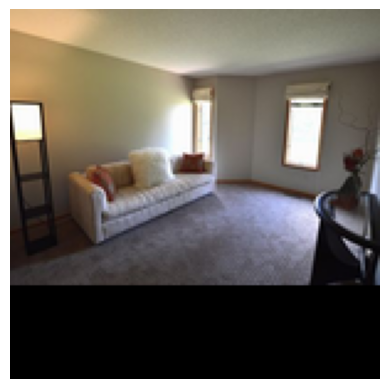

In [33]:
import matplotlib.pyplot as plt
plt.imshow(X[0])
plt.axis('off')  # Turn off axis
plt.show()

In [34]:
X[:1]

[array([[[220, 180, 129],
         [220, 180, 129],
         [221, 181, 130],
         ...,
         [106, 104,  89],
         [104, 102,  87],
         [104, 102,  87]],
 
        [[222, 181, 130],
         [222, 182, 130],
         [223, 183, 131],
         ...,
         [108, 106,  91],
         [108, 106,  91],
         [105, 103,  88]],
 
        [[224, 183, 131],
         [225, 183, 132],
         [225, 184, 132],
         ...,
         [109, 107,  92],
         [108, 106,  91],
         [110, 108,  93]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

In [35]:
y[:5]

34425          Living Room
34426              Kitchen
34427                Other
34428              Bedroom
34429    Location Exterior
Name: label, dtype: object

Pick the data, and now it is good for the model.

In [36]:
import pickle

In [37]:
# Save pandas Series
with open('image_labels_X.npy', 'wb') as f:
    pickle.dump(X, f)

# Save NumPy array
with open('image_labels_y.npy', 'wb') as f:
    np.save(f, y)

In [38]:
y = labels[labels['image_path'].isin(paths)]['rank']

# Save NumPy array
with open('image_ranks_y.npy', 'wb') as f:
    np.save(f, y)

In [40]:
len(labels)

76925

In [41]:
labels.to_csv('training_data_images.csv')